# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1zky5H4xVWg2kNukdWn8pLkbD9gZp5q7J?usp=sharing

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

In [50]:
%%shell
jupyter nbconvert --to html /content/Fall_2023_Lab4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/Fall_2023_Lab4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 950516 bytes to /content/Fall_2023_Lab4_Data_Imputation.html


## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [8]:
# First we will determine the minimum value of each category:

subheader = ["age", "yredu", "capgain", "caploss", "workhr"]

min_list = []

for label in subheader:
  min_label = np.min(subdf[label])
  min_list.append(min_label)

print(min_list)

# Next we determine the maximum value of each category:

max_list = []

for label in subheader:
  max_label = np.max(subdf[label])
  max_list.append(max_label)

print(max_list)

# Now we calculate the average (mean) values:

mean_list = []

for label in subheader:
  mean_label = np.mean(subdf[label])
  mean_list.append(mean_label)

print(mean_list)


[17, 1, 0, 0, 1]
[90, 16, 99999, 4356, 99]
[38.58164675532078, 10.0806793403151, 1077.6488437087312, 87.303829734959, 40.437455852092995]


In [9]:
# Now we will normalize each value using min-max normalization, which will ensure our min = 0, max = 1, and all other values fall in the range of 0 to 1:

subheader = ["age", "yredu", "capgain", "caploss", "workhr"]

for label in subheader:
  df[label] = (df[label] - np.min(df[label])) / (np.max(df[label]) - np.min(df[label]))

df[:3] # to check that values in df were actually modified

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [11]:
percent_male = sum(df["sex"] == " Male")/32561*100                  # 32561 comes from the df.shape used prior (i.e., 32561 records)
percent_female = sum(df["sex"] == " Female")/32561*100

print("Percent male is", percent_male,"%")

print("Percent female is", percent_female,"%")

Percent male is 66.92054912318419 %
Percent female is 33.07945087681583 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [12]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"] # no country, fnlwgt, or race
features = contcols + catcols
df = df[features]
df[:3]

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
0,0.301370,0.800000,0.02174,0.0,0.397959,State-gov,Never-married,Adm-clerical,Bachelors,Not-in-family,Male
1,0.452055,0.800000,0.00000,0.0,0.122449,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Bachelors,Husband,Male
2,0.287671,0.533333,0.00000,0.0,0.397959,Private,Divorced,Handlers-cleaners,HS-grad,Not-in-family,Male


In [13]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [14]:
records_with_missing = len(df_with_missing) - 1      # subtract 1 as we do not count the header
print(records_with_missing, "records contained missing features.")

percent_removed = records_with_missing/(len(df) - 1)*100
print(percent_removed, "% of records were removed due to having missing features.")

1842 records contained missing features.
5.657248157248157 % of records were removed due to having missing features.


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [15]:
work_values = set(df_not_missing["work"])
print(work_values)

{' Self-emp-not-inc', ' State-gov', ' Private', ' Federal-gov', ' Without-pay', ' Self-emp-inc', ' Local-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [16]:
data = pd.get_dummies(df_not_missing)

In [17]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [18]:
data_columns = data.shape[1]
print(data_columns)

57


There are 57 columns (features) in the dataframe "data". It is the sum of all continuous features (age, yredu, capgain,caploss, workhr), and all possible options for categorical features (for example, there are various options for work, education, relationship status, sex, etc...). Having all of these columns is important for one-hot encoding, such that we can assign a unique identifier to each combination of features.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [19]:
datanp = data.values.astype(np.float32)

In [20]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """

    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.

    category_index = np.argmax(onehot)
    category = cat_values[feature][category_index]

    return category

In [21]:
print(cat_index)

{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}


In [22]:
print(cat_values)

{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


Cat_values tells us what the "options" are for each categorical variable. For example, "sex" feature has options "male" and "female". Cat_index tells us at which index a particular feature starts having options at. For example, "work" starts at index 5; this makes sense because indices 0 to 4 are for the continuous features.

In [23]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [24]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

np.random.shuffle(datanp)

print(datanp.shape) # there are 30718 records

train_end = int(datanp.shape[0]*0.7) # gets the index at which training set will end
val_end = int(datanp.shape[0]*0.85) # gets the index at which validation set will end

train_set = datanp[:train_end]
val_set = datanp[train_end:val_end]
test_set = datanp[val_end:]

print("There are",train_set.shape[0],"items in the train set.")
print("There are",val_set.shape[0],"items in the validation set.")
print("There are",test_set.shape[0],"items in the test set.")


(30718, 57)
There are 21502 items in the train set.
There are 4608 items in the validation set.
There are 4608 items in the test set.


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [25]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 15)
        )
        self.decoder = nn.Sequential(
            nn.Linear(15, 20),
            nn.ReLU(),
            nn.Linear(20, 30),
            nn.ReLU(),
            nn.Linear(30, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [26]:
train_set[:2] # visualizing two samples from the training set

array([[0.09589041, 0.46666667, 0.        , 0.        , 0.39795917,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        ],
       [0.60273975, 0.6       , 0.        , 0.        , 0.4489796 ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.     

We apply the sigmoid function at the end of the decoder since we want the outputs to fall within the range of 0 to 1; we want the outputs to be in this range since all the inputs are within the range of 0 to 1... we want the decoder to reconstruct the inputs.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [27]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

#############################################################################################################################

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss, val_loss, train_acc, val_acc = [], [], [], []



    for epoch in range(num_epochs):
        total_loss_in_epoch = 0
        batch_counter = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            total_loss_in_epoch += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            batch_counter += 1

        # The below portion of the training code keeps track of the values of train/validation loss/accuracy after each epoch:

        train_loss.append(total_loss_in_epoch/(batch_counter + 1)) # computing average loss over a batch
        val_loss.append(get_loss(model, valid_loader, criterion))
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, valid_loader))

    epochs = np.arange(1, num_epochs + 1)

    return train_loss, val_loss, train_acc, val_acc, epochs

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [28]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total


def get_loss(model, data_loader, criterion):
    accumulated_loss = 0
    batch_counter = 0

    for data in data_loader:
      datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
      recon = model(datam)
      loss = criterion(recon, data)
      accumulated_loss += loss.item()
      batch_counter += 1

    return accumulated_loss/(batch_counter + 1)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [29]:
import matplotlib.pyplot as plt

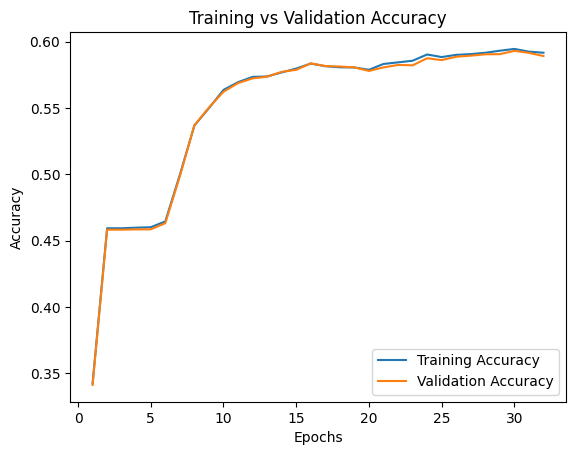

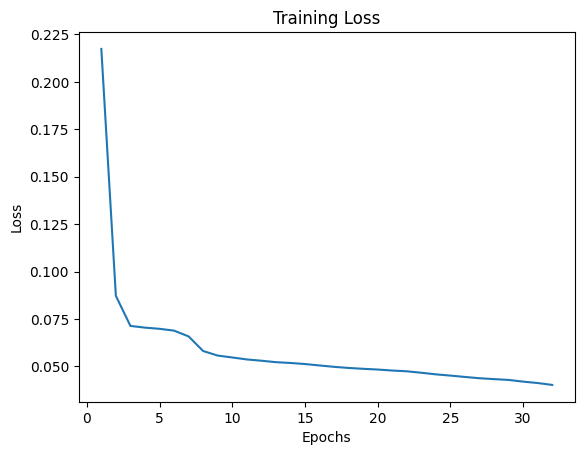

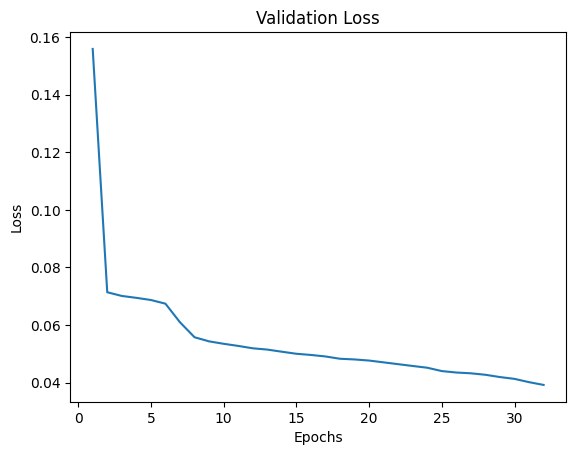

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

auto_encoder = AutoEncoder()

train_loss, val_loss, train_acc, val_acc, epochs = train(auto_encoder, train_loader, valid_loader, num_epochs=32, learning_rate=1e-4)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.title("Training Loss")
plt.plot(epochs, train_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.title("Validation Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

**Original Combination: batch size = 64, epochs = 32, learning rate = 0.0001**

I will first try keeping everything the same except for the learning rate, which I will increase to 1E-3:

**Trial 1: batch size = 64, epochs = 32, learning rate = 0.001**
This combination resulted in noisier training/validation accuracy curves, with the final accuracies being approximately the same as with the original set of hyperparameters. To reduce the noise while maintaining the new lr=0.001, I will try increasing the batch size.

**Trial 2: batch_size = 128, epochs, learning rate = 0.001**
This combination resulted, as expected, in less noisy training/validation accuracy curves. However, the final accuracy is more or less the same as the original trial and Trial 1 (about 60%). However, compared to the previous two, the accuracies in this trial seem to peak at about 12 epochs (about 61%) before slightly decreasing and plateuaing. For the next trial, I will try further increasing the batch size but lowering the learning rate. I am trying this to investigate an option where batch size is large and learning rate is small.

**Trial 3: batch size = 256, epochs = 32, learning rate = 0.0001**
This combination resulted in greatly reduced accuracy compared to all the other options (about 45% for most of the training). However, nearing 30 epochs it seems that the accuracies were starting to increase sharply. As such, for the next trial I will see what happens if I keep batch size = 256 and learning rate = 0.0001, but increase epochs to 64.

**Trial 4: batch size = 256, epochs = 64, learning rate = 0.0001**
This combination resulted in the expected continued increase which was described above; this sharp increase occured at about 35 epochs. After the sharp increase from accuracy of 45% to 52% at about 35 epochs, the accuracy continued to increase slowly with epochs. This trend continued for the rest of the training (64 epochs in total), with a final accuracy of 56%, which is still lower than the highest obtained final accuracy of 62%. However, to further investigate whether the upward trend would continue, I will again try increasing the epochs for the next trial.

**Trial 5: batch size = 256, epochs = 128, learning rate = 0.0001**
This combination seemed to plateau after about 100 epochs, with a final accuracy of about 60%. Looking back at all the trials done so far, it seems that Trials 2 and 5 have produced the best results (final accuracies for both are about 60%). One final combination I will try is to decrease the batch size to 128, but also decrease the learning rate to 0.0001 (Trial 2 had batch size 128 and learning rate of 0.001). This is to see if decreasing the learning rate with that batch size leads to better performance/prevents the peak/decrease which was described in Trial 2.

**Trial 6: batch size = 128, epochs = 128, learning rate = 0.0001**
This combination did not exhibit the peak/decrease which was seen in Trial 2, and also showed slight improvement in terms of accuracy, with a final accuracy of about 61%. As such, this will be the final chosen model and will be the model used in testing.

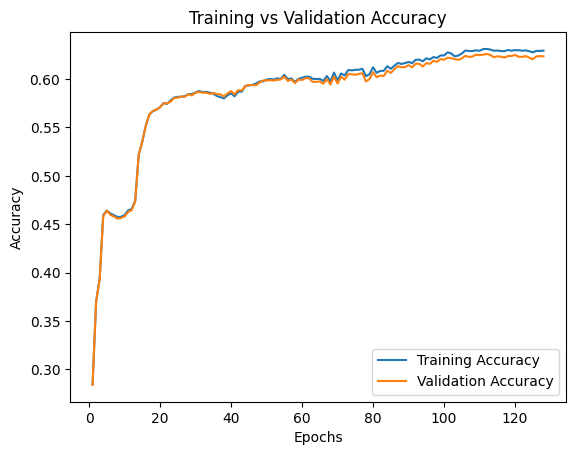

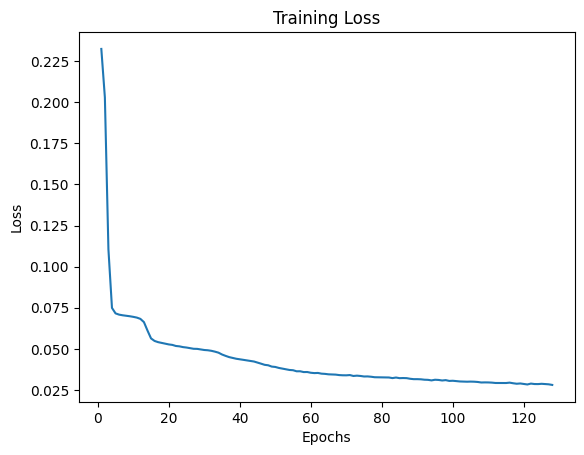

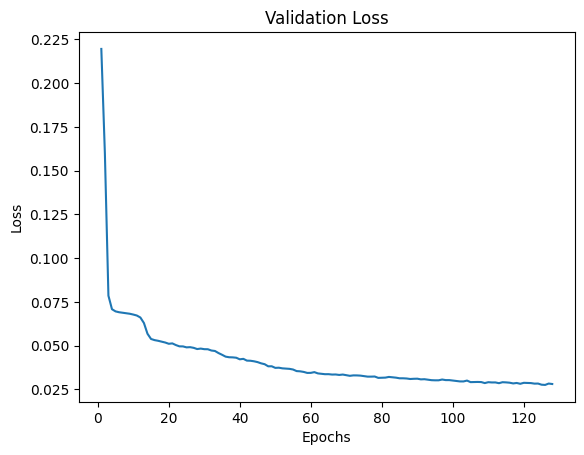

In [ ]:
## Final Model (Based on Trial 6 Hyperparameters)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=True)

auto_encoder = AutoEncoder()

train_loss, val_loss, train_acc, val_acc, epochs = train(auto_encoder, train_loader, valid_loader, num_epochs=128, learning_rate=1e-4)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.title("Training Loss")
plt.plot(epochs, train_loss, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.title("Validation Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)

print("The test accuracy is", get_accuracy(auto_encoder, test_loader))

The test accuracy is 0.6244936342592593


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [32]:
# First we want to identify the most common value for each feature in the training set...
# The pandas DataFrame.mode() will be useful for this...

catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]

most_common_values = {}

for category in catcols:
  most_common_values[category] = df.mode()[category].item()

print(most_common_values)

{'work': ' Private', 'marriage': ' Married-civ-spouse', 'occupation': ' Prof-specialty', 'edu': ' HS-grad', 'relationship': ' Husband', 'sex': ' Male'}


In [33]:
# Next we need to determine how the baseline will identify which feature is missing...
# A missing feature would result in the one-hot encoding of that feature to be all zeros...
# So we would loop through each category and check sum of the values in the one-hot encoding of each feature...

In [34]:
def baseline_model(record): # returns string of predicted (i.e., most common) value
  for category in catcols:
    if np.sum(get_onehot(record, category)) == 0:
      missing_category = category

  prediction = most_common_values[missing_category]

  return prediction

In [36]:
def zero_out_feature_single(record, feature): # this is a modification of the function zero_out_feature that will zero out one record at a time

    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    record[start_index:stop_index] = 0
    return record

In [35]:
def get_accuracy_baseline(data_set):
    correct = 0
    total = 0

    for record in data_set:
      random_choice = random.choice(catcols) # randomly choose a category to zero out

      record_with_missing = zero_out_feature_single(np.copy(record), random_choice) # zero out the randomly chosen categorical feature
      prediction = baseline_model(record_with_missing) # prediction is the one-hot encoding of the most common value in missing category
      prediction = prediction.strip()

      # next, we need to compare the prediction with the category value that was zeroed out; we need to find the one-hot encoding in the original record
      # we know which category was zeroed out thanks to random_choice, so we can make use of cat_index to find the one-hot encoding

      start_index = cat_index[random_choice]
      stop_index = cat_index[random_choice] + len(cat_values[random_choice])

      actual_value_one_hot = record[start_index:stop_index] # one-hot encoding of the zeroed out value

      actual_value = get_categorical_value(actual_value_one_hot, random_choice) # string of zeroed out value (i.e., "Private")
      actual_value = actual_value.strip()

      if actual_value == prediction:
        correct += 1

      total += 1

    return correct/total


In [32]:
# Finding accuracy of baseline on the test set:

get_accuracy_baseline(test_set)

0.4602864583333333

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The baseline test accuracy is about 16% lower than the test accuracy from Part A.



### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [37]:
for category in catcols:
  print(category + ": " + get_categorical_value(get_onehot(test_set[0], category), category))

work: Private
marriage: Divorced
occupation: Prof-specialty
edu: Bachelors
relationship: Not-in-family
sex: Male


No, given that this individual's occupation is "Prof-specialty", one would assume they have a PhD, not a Bachelor's.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [48]:
test_input = torch.from_numpy(zero_out_feature_single(test_set[0], "edu"))

auto_encoder = AutoEncoder()

prediction = auto_encoder(test_input)

result = prediction.detach().numpy() # numpy array of reconstructed input (i.e., with missing category filled in)

print("Predicted Education Level is:", get_categorical_value(get_onehot(result, 'edu'), 'edu'))

Predicted Education Level is: Some-college


The predicted education level by the model is "Some-college"

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [49]:
test_input = zero_out_feature_single(test_set[0], "edu")

baseline_prediction = baseline_model(test_input)

print("Predicted Education Level is:", baseline_prediction)

Predicted Education Level is:  HS-grad


THe baseline model predicts Highschool Grad as the education level since that is the most common value in the training set.